# How to integrate Financial Data from Refinitiv Data Platform Libraries to Excel with Xlwings

## Introduction

In [1]:
# import xlwings and RDP libraries
import xlwings as xw
import refinitiv.dataplatform as rdp

In [2]:
# import all required libraries for this notebook
import datetime
import configparser as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tick
import json

You should save a text file with **filename** `rdp.cfg` having the following contents:

    [rdp]
    username = YOUR_RDP_EMAIL_USERNAME
    password = YOUR_RDP_PASSWORD
    app_key = YOUR_RDP_APP_KEY
    
This file should be readily availble (e.g. in the current working directory) for the next steps.

In [3]:
cfg = cp.ConfigParser()
cfg.read('rdp.cfg')

['rdp.cfg']

In [4]:
# Open RDP Platform Session
session = rdp.open_platform_session(
    cfg['rdp']['app_key'], 
    rdp.GrantPassword(
        username = cfg['rdp']['username'], 
        password = cfg['rdp']['password']
    )
)
session.get_open_state()

<State.Open: 3>

Firstly, we will use RDP Function Layer to request time-series data as a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object. 

In [5]:
# Declare parameter(s)
universe = 'VOD.L'
historical_title = '%s Historical Data' % (universe)

In [6]:
df_historical = rdp.get_historical_price_summaries(
    universe = universe,
    interval = rdp.Intervals.DAILY,
    count = 90,
    fields = ['BID','ASK','OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1','NUM_MOVES']
    )
df_historical

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
2020-06-03,136.54,136.58,135.1,136.66,133.38,134.04,17076
2020-06-04,137.12,137.16,135.8,137.44,134.86,137.16,10010
2020-06-05,138.94,138.96,137.5,139.08,136.08,138.96,11592
2020-06-08,141.12,141.14,137.34,142.44,137.04,141.58,15718
2020-06-09,138.94,139,140.52,141.66,138.3,139.6717,16127
...,...,...,...,...,...,...,...
2020-10-01,101.68,101.7,103.6,104.52,101.18,101.9048,10157
2020-10-02,102.8,102.82,101.7,102.84,100.54,102.68,11249
2020-10-05,107.66,107.68,104.5,107.88,103.92,105.8525,15291
2020-10-06,110.18,110.36,108.98,111.22,107.6,108.9,13483


With xlwings, we can export this ```df_historical``` DataFrame to excel directly.

The first step is initiate xlwings object.

In [7]:
wb = xw.Book("") # Creating an new excel file. wb = xw.Book(filename) would open an existing file

The above step initiates xlwings Work Book class in ```wb``` object. The ```wb = xw.Book("")``` statment creates a new excel file. If you are using ```wb = xw.Book(filename)```, the xlwings will open an existing file.

<img src="images/report_1.png">

In [8]:

# Select the first excel sheet, and rename the first Sheet
historical_sheet = wb.sheets[0]
historical_sheet.name = historical_title

<img src="images/report_2_rename_sheet.png">

Then you can just pass your dataframe object to ```sheet.range(<cell>).value``` property to set Pandas DataFrame to excel directly.

In [9]:
# Set historical_sheet dataframe to cell A1

historical_sheet.range("A1").value = df_historical.head(30)

<img src="images/report_3_dataframe.png">

That is, the application is ready to get and export Refinitiv Data to excel file.

The above example show how to export data "as is" which often hard to read. The application can use xlwings API to customize excel report look and feel along side and customize Pandas DataFrame to make data more easy to understand.

In [10]:
# Clear current sheet
historical_sheet.clear()

Then we use xlwings ```Sheet``` object and its ```api``` property to change report look and feel.

In [11]:
historical_sheet.range("A1").value = historical_title
historical_sheet.range("A1").api.Font.Size = 14 # Change font color
historical_sheet.range("A1").api.Font.ColorIndex = 2 # Change font color
historical_sheet.range('A1:H1').color = (0,0,255) # Change cell background color

The above statmens create the following excel  report look and feel.

<img src="images/report_4.png">

Next, we re-stucture ```df_historical``` DataFrame to make it easier to read by naming the index column to "Date"

In [12]:
df_historical.index.name = 'Date'
df_historical.head(5)

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
Date,,,,,,,
2020-06-03,136.54,136.58,135.1,136.66,133.38,134.04,17076
2020-06-04,137.12,137.16,135.8,137.44,134.86,137.16,10010
2020-06-05,138.94,138.96,137.5,139.08,136.08,138.96,11592
2020-06-08,141.12,141.14,137.34,142.44,137.04,141.58,15718
2020-06-09,138.94,139,140.52,141.66,138.3,139.6717,16127


Next, we set the DataFrame to *A2* cell, then set column header font and background color to make them distinguish from data

In [15]:
historical_sheet.range("A2").value = df_historical.head(30)

#Make Column headers bold
historical_sheet.range('2:1').api.Font.Bold = True
# Change cell background color
historical_sheet.range('A2:H2').color = (144,238,144) 
# Set sheet autofit the width of row
historical_sheet.autofit('r')

The result is the following readable report table:

<img src="images/report_5.png">

## Ploting a Graph

Firstly, we change all non-Date columns data type from String to Float.

In [16]:
for column in df_historical:
    df_historical[column]=df_historical[column].astype(float)

 we change the DataFrame Date index to be a data column. This will let us plot a graph using **Date** as X-Axis.

In [17]:
df_historical.reset_index(level=0, inplace=True)
df_historical.head(5)

,Date,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
0,2020-06-03,136.54,136.58,135.10,136.66,133.38,134.0400,17076.0
1,2020-06-04,137.12,137.16,135.80,137.44,134.86,137.1600,10010.0
2,2020-06-05,138.94,138.96,137.50,139.08,136.08,138.9600,11592.0
3,2020-06-08,141.12,141.14,137.34,142.44,137.04,141.5800,15718.0
4,2020-06-09,138.94,139.00,140.52,141.66,138.30,139.6717,16127.0


In [18]:
# Sort DataFrame by Date
df_historical.sort_values('Date',ascending=True,inplace=True)

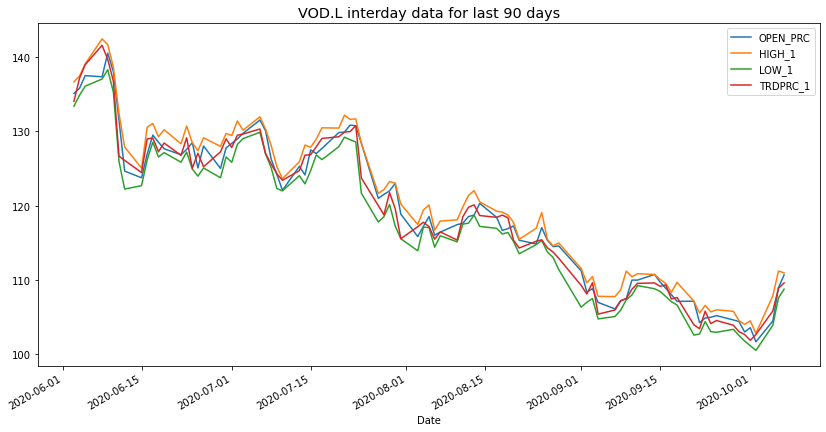

In [19]:
# Plotting a Graph

columns = ['OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1']

df_historical.set_index('Date',drop=True,inplace=True)
fig = plt.figure()
#Format Total Sale display unit as a graph footer.
#fig.text(.5, -.05, 'Open High Low', ha='center',fontsize='large')

# Create graph title from Company and RIC names dynamically.
plt.ticklabel_format(style = 'plain')
plt.title('VOD.L interday data for last 90 days', color='black',fontsize='x-large')
ax = fig.gca()

#df_historical.plot(x="Date", y=columns,figsize=(14,7) )
df_historical.plot(kind='line', ax = fig.gca(),y=columns,figsize=(14,7) )
plt.show()

In [20]:
historical_last_row = historical_sheet.range('A' + str(historical_sheet.cells.last_cell.row)).end('up').row
historical_last_row

32

In [21]:
rng = historical_sheet.range('B{row}'.format(row = historical_last_row + 3))
rng

<Range [Book1]VOD.L Historical Data!$B$35>

In [22]:
historical_sheet.pictures.add(fig, name='MyPlot', update=True, top=rng.top, left=rng.left)

<Picture 'MyPlot' in <Sheet [Book1]VOD.L Historical Data>>

The result is the following readable report table:

<img src="images/report_6.png">

Then we save this excel file with xlwings ```Book``` object ```save()``` function.

In [24]:
wb.save('rdp_report.xlsx')

### Close RDP Session

In [23]:
# -- Close Session, just calls close_session() function

rdp.close_session()

print(session.get_open_state())

State.Closed


## References

You can find more detail regarding the Refinitiv Data Platform Libraries, Xlwings and related technologies for this notebook from the following resources:
* [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) web site.
* [Xlwings web site](https://www.xlwings.org/).
* [RDP Libraries Quick Start Guide page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start).
* [RDP Libraries Tutorial page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/tutorials).
* [Xlwings Document page](https://docs.xlwings.org/en/stable/).
* [Discover our Refinitiv Data Platform Library (part 1)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-1).
* [Discover our Refinitiv Data Platform Library (part 2)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-2).
* [Financial Reporting with Eikon and Excel](https://developers.refinitiv.com/en/article-catalog/article/financial-reporting-with-eikon-and-excel).
* [Xlwings API Reference](https://docs.xlwings.org/en/stable/api.html).

For any question related to this article or Refinitiv Data Platform Libraries, please use the Developers Community [Q&A Forum](https://community.developers.refinitiv.com/spaces/321/refinitiv-data-platform-libraries.html).